In [65]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Read excel file, sheet excess returns
etfData = pd.read_excel('../data/proshares_analysis_data.xlsx', 'hedge_fund_series')
# Set the index to Date (rather than default 0 indexing)
etfData.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
etfData = etfData.set_index('Date')
# Display top rows for validation
etfData.head()

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Date,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027035,-0.006489
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032465,-0.022144
2011-10-31,0.026858,0.043593,0.043320,0.050530,0.025241
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028606,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012875,0.001823


In [61]:
# 1: Report mean, volatility, and Sharpe ratio. Annualize
def portfolio_stats(data):
    # Calculate the mean and annualize
    mean = data.mean() * 12

    # Volatility = standard deviation
    # Annualize the result with sqrt(12)
    vol = data.std() * np.sqrt(12)

    # Sharpe Ratio is mean / vol
    sharpe_ratio = mean / vol

    # Format for easy reading
    return round(pd.DataFrame(data = [mean, vol, sharpe_ratio], 
        index = ['Mean', 'Volatility', 'Sharpe']), 4)
    
portfolio_stats(etfData)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Mean,0.0429,0.0257,0.0243,0.0140,0.0116
Volatility,0.0609,0.0569,0.0567,0.0592,0.0489
Sharpe,0.7038,0.4513,0.4283,0.2365,0.2366


In [62]:
# 2. Tail Risk
# Takes data and quantile, and returns:
#      Skewness
#      Excess Kurtosis
#      VaR (q) -> the q-th quantile of historic returns
#      CVaR (q) -> the mean of returns at or below the q-th quantile
#      Maximum drawdown 
def tail_risk_report(data, q):
    df = data.copy()
    df.index = data.index.date
    report = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness'] = df.skew()
    report.loc['Excess Kurtosis'] = df.kurtosis()
    report.loc['VaR'] = df.quantile(q)
    report.loc['CVaR'] = df[df < df.quantile(q)].mean()
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()
    report.loc['Drawdown Start'] = None
    report.loc['Drawdown End'] = drawdown.idxmin()
    report.loc['Recovery Date'] = None
    
    for col in df.columns:
        report.loc['Drawdown Start', col] = (rolling_max.loc[:report.loc['Drawdown End', col]])[col].idxmax()
        recovery_df = (drawdown.loc[report.loc['Drawdown End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col] = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['Drawdown Start']).dt.days
        except:
            report.loc['Recovery Date', col] = None
            report.loc['Recovery period (days)'] = None

    return round(report,4)

tail_risk_report(etfData, 0.05)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Skewness,-1.020683,-0.315513,-0.304807,-0.298573,-0.634129
Excess Kurtosis,6.163102,1.778696,1.741807,1.931106,1.913339
VaR,-0.025585,-0.029652,-0.029867,-0.031528,-0.021245
CVaR,-0.039205,-0.036865,-0.036763,-0.038482,-0.034401
Max Drawdown,-0.115473,-0.124302,-0.124388,-0.14072,-0.137714
Drawdown Start,2019-12-31,2021-06-30,2021-06-30,2021-06-30,2021-06-30
Drawdown End,2020-03-31,2022-09-30,2022-09-30,2022-09-30,2022-09-30
Recovery Date,2020-08-31,None,None,None,None
Recovery period (days),None,None,None,None,None


It is interesting to note in the above data that many of the indexes are currently in their max drawdown and have not yet begun to recover.

In [63]:
# 3. Regression based statistics against SPY
# First get SPY
factor_data = pd.read_excel('../data/proshares_analysis_data.xlsx', sheet_name = 'merrill_factors')
factor_data.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
factor_data = factor_data.set_index('Date')
def regression_stats(df):
    reg_stats = pd.DataFrame(data = None, index = df.columns, columns = ['beta', 
                                                                         'Treynor Ratio', 
                                                                         'Information Ratio'])
    for col in df.columns:
        # Drop the NAs in y
        y = df[col].dropna()
        # Align the X with y - this is us including the intercept
        X = sm.add_constant(factor_data['SPY US Equity'].loc[y.index])
        reg = sm.OLS(y, X).fit()
        reg_stats.loc[col, 'beta'] = reg.params[1]
        # Treynor is calulated as mean/beta
        reg_stats.loc[col, 'Treynor Ratio'] = (df[col].mean() * 12) / reg.params[1]
        reg_stats.loc[col, 'Information Ratio'] = (reg.params[0] / reg.resid.std()) * np.sqrt(12)

    return reg_stats.astype(float).round(4)

regression_stats(etfData)

,beta,Treynor Ratio,Information Ratio
HFRIFWI Index,0.3500,0.1225,0.0130
MLEIFCTR Index,0.3549,0.0723,-0.7315
MLEIFCTX Index,0.3536,0.0687,-0.7846
HDG US Equity,0.3631,0.0386,-1.1237
QAI US Equity,0.2919,0.0397,-0.9838


- Beta < 1 indicates that for every dollar of SPY, the indexes go up by less than that dollar. Lower beta = less risk because of reverse slope.
- Treynor Ratio measures return based on systematic risk (like Sharpe but based on beta instead). Based on this analysis, the HFRIFWI Index has the best return for systematic risk compared to the others.
- The only Index with IR > 0 is HFRIFWI, indicating it's the only index which beat the market on this time frame


4. Relative Performance

<br/>   a) The preceding statistics show that all of the hedge-funds are less volatile than SPY, and that HFRIFWI was the only one to beat SPY in terms of returns.
<br/>   b) Though HDG has a higher mean, I would say that QAI performs better, because it has the higher Sharpe and information ratio.
<br/>   c) I would argue that HDG and ML do not capture the notable properties of HFRI. HFRI had the only positive information ratio, a higher Sharpe ratio, and was significantly more skewed. Additionally, HFRI had an excess kurtosis of more than three times the others.

MIN Correlation pair is ('HFRIFWI Index', 'QAI US Equity') with value 0.9999389069229563
MAX Correlation pair is ('MLEIFCTX Index', 'MLEIFCTR Index') with value 0.8384824348734503


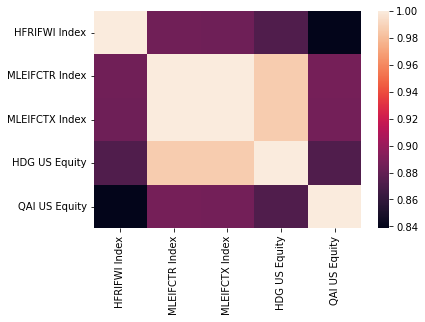

In [72]:
# 5. Display Correlation Matrix as heatmap
correlationMatrix = etfData.corr()
sns.heatmap(correlationMatrix)

# Find min and max correlations (remove 1)
correlationMatrix[correlationMatrix==1] = None
corr_rank = correlationMatrix.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min} with value {corr_rank[-1]}')
print(f'MAX Correlation pair is {pair_max} with value {corr_rank[0]}')